In [ ]:
"this notebook goes through the process of collecting data and etc "

In [3]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import seaborn as sns
from dataClasses import Trial,Neuron
from sklearn.feature_selection import RFECV
from sklearn import svm
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report
import warnings
import random
import math
import itertools

# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

from imblearn.under_sampling import RandomUnderSampler
import pandas as pd


In [4]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Defining the RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        
        # RNN forward pass
        out, _ = self.rnn(x)
        
        # Use only the last time step's output
        out = out[:, -1]  # Take the output from the last sequence step
        
        # Fully connected layer
        out = self.fc(out)
        
        return out


In [6]:
def get_data_ready(brain_area, type_of_analysis):
    all_trials=np.load("processed_data/"+brain_area + "_all_trials.npy",allow_pickle=True)
    trial_list=np.empty((all_trials.shape[0],3))
    trial_dff=np.empty((all_trials.shape[0],41)) 
    trial_licks=np.empty((all_trials.shape[0],41))
    # Here we get the data based on the conditions that we want (i.e: if it is is lick, or go) 
    
    for trial in range(all_trials.shape[0]):
        
        trial_list[trial,0]=all_trials[trial].neuron_num
    
        
        if type_of_analysis=="GO":
            # for labelling go nogo
            if (all_trials[trial].trial_type)=="go":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_type)=="nogo":
                trial_list[trial,1]=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num )
        elif type_of_analysis=="LICK":    
            #for labelling lick nolick
            if (all_trials[trial].trial_outcome)=="FA":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_outcome)=="Hit":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_outcome)=="Miss":
                trial_list[trial,1]=0
            elif (all_trials[trial].trial_outcome)=="CR":
                trial_list[trial,1]=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num )
        else:
            print("Type of analysis can only be 'GO' or 'LICK'")
        
        trial_list[trial,2]=all_trials[trial].mouse_id
        if (all_trials[trial].trial_outcome)=="FA" or (all_trials[trial].trial_outcome)=="Hit":
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #rebase  dff 
            trial_licks[trial,:]=all_trials[trial].licks
            lick_start=np.argmax(trial_licks[trial,:]==1,axis=0)
            trial_dff_rel_licks=np.zeros(trial_licks.shape[1])
            new_start=lick_start-4
            if new_start>=0:                    
                # move the array of licks left so that timeseries starst at lick time
                trial_dff_rel_licks[0:trial_licks.shape[1]-new_start]=all_trials[trial].dff[new_start: ]
                ## need to mske the last few timesteps on the new series = final timestep on original series
                trial_dff_rel_licks[trial_licks.shape[1]-new_start :]=all_trials[trial].dff[-1]
            else: 
                # move the array of licks right so that timeseries starst at lick time
                trial_dff_rel_licks[0-new_start :]=all_trials[trial].dff[0:all_trials[trial].dff.shape[0]+new_start]
                ## need to mske the first few timesteps on the new series = first timestep on original series
                trial_dff_rel_licks[0:-new_start]=all_trials[trial].dff[ 0 ]
                #trial_dff[trial,41:82]=trial_dff_rel_licks
        else:
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #trial_dff[trial,41:82]=all_trials[trial].dff
    return trial_list, trial_dff


In [ ]:
#no balancing
# Number of permutations for testing
num_permutations = 1000

# Brain areas and analysis types
results = []
brain_areas = ["S1", "S1naive", "PPC"]
type_of_analysis = ["GO", "LICK"]

combinations = list(itertools.product(brain_areas, type_of_analysis))

# Iterate through each combination
for brain_area, type_of_analysis in combinations:
    print(f"Brain Area: {brain_area}, Analysis Type: {type_of_analysis}")
    trial_list, trial_dff = get_data_ready(brain_area, type_of_analysis)

    neuron_list = np.unique(trial_list[:, 0]).reshape(-1, 1)
    print("Num of neurons before filter=", neuron_list.shape[0])

    for neuron in neuron_list:
        print("\n", neuron, "XXXXXXXXXXXXXXXXXXXX")
        
        # Extract neuron-specific data
        neuron_data_list = trial_list[trial_list[:, 0] == neuron].copy()
        neuron_data_dff = trial_dff[trial_list[:, 0] == neuron].copy()

        X = neuron_data_dff.copy()
        y = neuron_data_list[:, 1]

        X = X.reshape(X.shape[0], X.shape[1], 1)

        #### Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Convert to tensors
        Xtrain = torch.from_numpy(X_train).float()
        ytrain = torch.from_numpy(y_train).long()
        Xtest = torch.from_numpy(X_test).float()
        ytest = torch.from_numpy(y_test).long()

        # Batch size, epochs, and iterations
        batch_size = 16
        n_iters = 1000
        num_epochs = int(n_iters // (len(X_train) // batch_size))

        train = TensorDataset(Xtrain, ytrain)
        test = TensorDataset(Xtest, ytest)

        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)

        # Create the RNN model
        input_dim = X.shape[-1]
        hidden_dim = 4
        layer_dim = 1
        output_dim = 1

        model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

        # Loss function and optimizer WITHOUT weights
        error = nn.BCEWithLogitsLoss()
        learning_rate = 0.001
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        # Training loop for the original model
        train_accuracy_list = []
        test_accuracy_list = []
        test_loss_list = []

        for epoch in range(num_epochs):
            model.train()
            total_train, correct_train = 0, 0

            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch).squeeze()
                loss = error(outputs, y_batch.float())
                loss.backward()
                optimizer.step()

                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities > 0.5).long()
                correct_train += (predicted.squeeze() == y_batch).sum().item()
                total_train += y_batch.size(0)

            train_accuracy = 100 * correct_train / total_train
            train_accuracy_list.append(train_accuracy)
            scheduler.step()

            # Evaluate on test set
            model.eval()
            total_test, correct_test = 0, 0
            with torch.no_grad():
                for X_test_batch, y_test_batch in test_loader:
                    outputs = model(X_test_batch).squeeze()
                    probabilities = torch.sigmoid(outputs)
                    predicted = (probabilities > 0.5).long()
                    correct_test += (predicted == y_test_batch).sum().item()
                    total_test += y_test_batch.size(0)
                    loss_test = error(outputs, y_test_batch.float())
                    test_loss_list.append(loss_test)

            test_accuracy = 100 * correct_test / float(total_test)
            test_accuracy_list.append(test_accuracy)

        # Save the original model's test accuracy
        original_test_accuracy = test_accuracy

        # Permutation testing
        perm_test_accuracies = []

        for perm in range(num_permutations):
            y_permuted = np.random.permutation(y_train)  # Shuffle the labels
            ytrain_perm = torch.from_numpy(y_permuted).long()
            perm_train = TensorDataset(Xtrain, ytrain_perm)
            perm_train_loader = DataLoader(perm_train, batch_size=batch_size, shuffle=True, drop_last=True)

            model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)  # Reinitialize model
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            # Train on permuted data
            for epoch in range(num_epochs):
                model.train()
                for X_batch, y_batch in perm_train_loader:
                    optimizer.zero_grad()
                    outputs = model(X_batch).squeeze()
                    loss = error(outputs, y_batch.float())
                    loss.backward()
                    optimizer.step()

            # Test accuracy on original test set
            model.eval()
            perm_correct_test, perm_total_test = 0, 0
            with torch.no_grad():
                for X_test_batch, y_test_batch in test_loader:
                    outputs = model(X_test_batch).squeeze()
                    probabilities = torch.sigmoid(outputs)
                    predicted = (probabilities > 0.5).long()
                    perm_correct_test += (predicted == y_test_batch).sum().item()
                    perm_total_test += y_test_batch.size(0)

            perm_test_accuracy = 100 * perm_correct_test / float(perm_total_test)
            perm_test_accuracies.append(perm_test_accuracy)

        # Calculate p-value
        perm_test_accuracies = np.array(perm_test_accuracies)
        p_value = np.mean(perm_test_accuracies >= original_test_accuracy)

        # Store results
        results.append({
            'Brain Area': brain_area,
            'Analysis Type': type_of_analysis,
            'Neuron': neuron,
            'Test Accuracy': original_test_accuracy,
            'p value': p_value
        })

        print(f"Neuron {neuron}: Test Accuracy = {original_test_accuracy:.2f}%, p-value = {p_value:.4f}")


In [ ]:
''' 
no fix for balancing 
'''
results= []
# Brain areas and analysis types
brain_areas = ["S1", "S1naive", "PPC"]
type_of_analysis = ["GO", "LICK"]

# Create all combinations
combinations = list(itertools.product(brain_areas, type_of_analysis))

# Iterate through each combination
for brain_area, type_of_analysis in combinations:
    print(f"Brain Area: {brain_area}, Analysis Type: {type_of_analysis}")
    trial_list, trial_dff= get_data_ready(brain_area, type_of_analysis)
   
    print("Array of neuron_num and trial type",trial_list.shape)
    print("Array of dff",trial_dff.shape)
    neuron_list=np.unique(trial_list[:,0]).reshape(-1,1)
    print("Num of neurons before filter=",neuron_list.shape[0])

    for neuron in neuron_list:
        print("\n", neuron, "XXXXXXXXXXXXXXXXXXXX")
    
        neuron_data_list = trial_list[trial_list[:, 0] == neuron].copy()
        neuron_data_dff = trial_dff[trial_list[:, 0] == neuron].copy()
    
        X = neuron_data_dff.copy()
        y = neuron_data_list[:, 1]
        #trying the dims
        X = X.reshape(X.shape[0],X.shape[1],1)
         
        #### Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        # Convert to tensors
        Xtrain = torch.from_numpy(X_train).float()
        ytrain = torch.from_numpy(y_train).long()  # Assuming classification
        Xtest = torch.from_numpy(X_test).float()
        ytest = torch.from_numpy(y_test).long()
        
        # Batch size, epochs, and iterations
        batch_size = 16
        n_iters = 1000#0
        num_epochs = n_iters // (len(X_train) // batch_size)
        num_epochs = int(num_epochs)
        print(num_epochs)

        # Pytorch train and test sets
        train = TensorDataset(Xtrain, ytrain)
        test = TensorDataset(Xtest, ytest)
    
        # Data loaders
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last= True) # this will drop the last batch if its size is less than the batch size, preventing issues caused by small batch sizes
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)


        # Create the RNN model
        input_dim = X.shape[-1]
        hidden_dim = 4
        layer_dim = 1
        output_dim = 1
    
        model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
    
        # Loss function and optimizer WITHOUT weights
        error = nn.BCEWithLogitsLoss()
        learning_rate = 0.001
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
        
        loss_list = []
        iteration_list = []
        train_accuracy_list = []
        test_accuracy_list= []
        count = 0
        test_loss_list=[]
    
    
        for epoch in range(num_epochs):
            total_train = 0
            correct_train = 0
            total_test = 0
            correct_test = 0
            model.train()
            for i, (X_batch, y_batch) in enumerate(train_loader):
    
                # Clear gradients
                optimizer.zero_grad()
    
                # Forward pass
                outputs = model(X_batch)
                outputs=outputs.squeeze()
               
                loss = error(outputs, y_batch.float())
    
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Apply sigmoid to get probabilities
                probabilities = torch.sigmoid(outputs)
    
                # Convert probabilities to binary class predictions using a threshold (0.5)
                predicted = (probabilities > 0.5).long()
    
                # Count total number of samples in the batch
                total_train += y_batch.size(0)
               # print("total",total)
                # Count correct predictions
                correct_train += (predicted.squeeze() == y_batch).sum().item()
                     # Calculate accuracy
            train_accuracy = 100 * correct_train / total_train
                #print(f"Train Accuracy: {accuracy:.2f}%")
            train_accuracy_list.append(train_accuracy)
       
                
            scheduler.step()
            correct_test=0
            total_test=0

        
            model.eval()
            with torch.no_grad():
                for X_test_batch, y_test_batch in test_loader:
                    outputs = model(X_test_batch)#.squeeze
                    outputs = outputs.squeeze()
                    #apply sigmoid for accuracy
                    probabilities=torch.sigmoid(outputs)
                  #  print(probabilities)
                    predicted = (probabilities >0.5).long()
                    total_test += y_test_batch.size(0)
                    correct_test += (predicted == y_test_batch).sum().item()
                    loss_test = error(outputs, y_test_batch.float())
                    test_loss_list.append(loss_test)
                    
                test_accuracy = 100 * correct_test / float(total_test)#
                test_accuracy_list.append(test_accuracy)
    
          #  print(f"Test Accuracy: {accuracy:.2f}%")
    
            # Store loss and accuracy
            loss_list.append(np.mean(test_loss_list).item())
            iteration_list.append(count)
            count+=1 
            #print(loss)
            print(f'Epoch: {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%', "loss:", np.mean(test_loss_list))


        results.append({
                'Brain Area': brain_area,
                'Analysis Type': type_of_analysis,
                'Neuron': neuron,
                'Test Accuracy': test_accuracy,
                'p value': p_value
            })
        
        '''
        # Visualization
        plt.plot(iteration_list, loss_list)
        plt.xlabel("Number of iterations")
        plt.ylabel("Loss")
        plt.title("RNN: Loss vs Number of iterations")
        plt.show()
    
        print(len(test_accuracy_list), test_accuracy_list)
    
        plt.plot(iteration_list, test_accuracy_list, color="red", label="test")
        plt.plot(iteration_list, train_accuracy_list, color="blue", label="train")
        plt.xlabel("Number of iterations")
        plt.ylabel("Accuracy")
        plt.title("RNN: Accuracy vs Number of iterations")
        plt.legend()
        plt.show()
        '''



In [ ]:
''' SELECT VALUES HERE
This uses weghted loss function to deal with the imbalanced classes 
'''
results= []
# Brain areas and analysis types
brain_areas = ["S1", "S1naive", "PPC"]
type_of_analysis = ["GO", "LICK"]

# Create all combinations
combinations = list(itertools.product(brain_areas, type_of_analysis))

# Iterate through each combination
for brain_area, type_of_analysis in combinations:
    print(f"Brain Area: {brain_area}, Analysis Type: {type_of_analysis}")

    all_trials=np.load("processed_data/"+brain_area + "_all_trials.npy",allow_pickle=True)
    trial_list=np.empty((all_trials.shape[0],3))
    trial_dff=np.empty((all_trials.shape[0],41)) 
    trial_licks=np.empty((all_trials.shape[0],41))
    
    
    # Here we get the data based on the conditions that we want (i.e: if it is is lick, or go) 
    
    for trial in range(all_trials.shape[0]):
        
        trial_list[trial,0]=all_trials[trial].neuron_num
    
        
        if type_of_analysis=="GO":
            # for labelling go nogo
            if (all_trials[trial].trial_type)=="go":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_type)=="nogo":
                trial_list[trial,1]=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num )
        elif type_of_analysis=="LICK":    
            #for labelling lick nolick
            if (all_trials[trial].trial_outcome)=="FA":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_outcome)=="Hit":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_outcome)=="Miss":
                trial_list[trial,1]=0
            elif (all_trials[trial].trial_outcome)=="CR":
                trial_list[trial,1]=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num )
        else:
            print("Type of analysis can only be 'GO' or 'LICK'")
        
        trial_list[trial,2]=all_trials[trial].mouse_id
        if (all_trials[trial].trial_outcome)=="FA" or (all_trials[trial].trial_outcome)=="Hit":
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #rebase  dff 
            trial_licks[trial,:]=all_trials[trial].licks
            lick_start=np.argmax(trial_licks[trial,:]==1,axis=0)
            trial_dff_rel_licks=np.zeros(trial_licks.shape[1])
            new_start=lick_start-4
            if new_start>=0:                    
                # move the array of licks left so that timeseries starst at lick time
                trial_dff_rel_licks[0:trial_licks.shape[1]-new_start]=all_trials[trial].dff[new_start: ]
                ## need to mske the last few timesteps on the new series = final timestep on original series
                trial_dff_rel_licks[trial_licks.shape[1]-new_start :]=all_trials[trial].dff[-1]
            else: 
                # move the array of licks right so that timeseries starst at lick time
                trial_dff_rel_licks[0-new_start :]=all_trials[trial].dff[0:all_trials[trial].dff.shape[0]+new_start]
                ## need to mske the first few timesteps on the new series = first timestep on original series
                trial_dff_rel_licks[0:-new_start]=all_trials[trial].dff[ 0 ]
                #trial_dff[trial,41:82]=trial_dff_rel_licks
        else:
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #trial_dff[trial,41:82]=all_trials[trial].dff

    print("Array of neuron_num and trial type",trial_list.shape)
    print("Array of dff",trial_dff.shape)
    neuron_list=np.unique(trial_list[:,0]).reshape(-1,1)
    print("Num of neurons before filter=",neuron_list.shape[0])

    for neuron in neuron_list:
        print("\n", neuron, "XXXXXXXXXXXXXXXXXXXX")
    
        neuron_data_list = trial_list[trial_list[:, 0] == neuron].copy()
        neuron_data_dff = trial_dff[trial_list[:, 0] == neuron].copy()
    
        X = neuron_data_dff.copy()
        y = neuron_data_list[:, 1]
        #trying the dims
        X = X.reshape(X.shape[0],X.shape[1],1)
    
    
         
        #### Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        # Convert to tensors
        Xtrain = torch.from_numpy(X_train).float()
        ytrain = torch.from_numpy(y_train).long()  # Assuming classification
        Xtest = torch.from_numpy(X_test).float()
        ytest = torch.from_numpy(y_test).long()
    
      
        
        # Batch size, epochs, and iterations
        batch_size = 16
        n_iters = 1000#0
        num_epochs = n_iters // (len(X_train) // batch_size)
        num_epochs = int(num_epochs)
        print(num_epochs)

        #Compute Class weghts for the training label
        class_weights= compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y=y_train)
        class_weights = torch.tensor(class_weights, dtype=torch.float)
        
        # Pytorch train and test sets
        train = TensorDataset(Xtrain, ytrain)
        test = TensorDataset(Xtest, ytest)
    
        # Data loaders
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last= True) # this will drop the last batch if its size is less than the batch size, preventing issues caused by small batch sizes
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
    
        # Create the RNN model
        input_dim = X.shape[-1]
        hidden_dim = 4
        layer_dim = 1
        output_dim = 1
    
        model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
    
        # Loss function and optimizer WITH WEIGHTS
        error = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])#applying class weights
        learning_rate = 0.001
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
        
        loss_list = []
        iteration_list = []
        train_accuracy_list = []
        test_accuracy_list= []
        count = 0
        test_loss_list=[]
    
    
        for epoch in range(num_epochs):
            total_train = 0
            correct_train = 0
            total_test = 0
            correct_test = 0
            model.train()
            for i, (X_batch, y_batch) in enumerate(train_loader):
    
               # print(f"X_batch shape: {X_batch.shape}")
               # print(f"y_batch shape: {y_batch.shape}")
                # Clear gradients
                optimizer.zero_grad()
    
                # Forward pass
                outputs = model(X_batch)
                outputs=outputs.squeeze()
               
                loss = error(outputs, y_batch.float())
    
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Apply sigmoid to get probabilities
                probabilities = torch.sigmoid(outputs)
    
                # Convert probabilities to binary class predictions using a threshold (0.5)
                predicted = (probabilities > 0.5).long()
    
                # Count total number of samples in the batch
                total_train += y_batch.size(0)
               # print("total",total)
                # Count correct predictions
                correct_train += (predicted.squeeze() == y_batch).sum().item()
                     # Calculate accuracy
            train_accuracy = 100 * correct_train / total_train
                #print(f"Train Accuracy: {accuracy:.2f}%")
            train_accuracy_list.append(train_accuracy)
       
                
            scheduler.step()
            correct_test=0
            total_test=0

        
            model.eval()
            with torch.no_grad():
                for X_test_batch, y_test_batch in test_loader:
                    outputs = model(X_test_batch)#.squeeze
                    outputs = outputs.squeeze()
                    #apply sigmoid for accuracy
                    probabilities=torch.sigmoid(outputs)
                  #  print(probabilities)
                    predicted = (probabilities >0.5).long()
                    total_test += y_test_batch.size(0)
                    correct_test += (predicted == y_test_batch).sum().item()
                    loss_test = error(outputs, y_test_batch.float())
                    test_loss_list.append(loss_test)
                    
                test_accuracy = 100 * correct_test / float(total_test)#
                test_accuracy_list.append(test_accuracy)
    
          #  print(f"Test Accuracy: {accuracy:.2f}%")
    
            # Store loss and accuracy
            loss_list.append(np.mean(test_loss_list).item())
            iteration_list.append(count)
            count+=1 
            #print(loss)
            print(f'Epoch: {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%', "loss:", np.mean(test_loss_list))
    
        results.append({
                'Brain Area': brain_area,
                'Analysis Type': type_of_analysis,
                'Neuron': neuron,
                'Test Accuracy': test_accuracy
            })
        # Visualization
        plt.plot(iteration_list, loss_list)
        plt.xlabel("Number of iterations")
        plt.ylabel("Loss")
        plt.title("RNN: Loss vs Number of iterations")
        plt.show()
    
        print(len(test_accuracy_list), test_accuracy_list)
    
        plt.plot(iteration_list, test_accuracy_list, color="red", label="test")
        plt.plot(iteration_list, train_accuracy_list, color="blue", label="train")
        plt.xlabel("Number of iterations")
        plt.ylabel("Accuracy")
        plt.title("RNN: Accuracy vs Number of iterations")
        plt.legend()
        plt.show()
        



In [9]:
import pandas as pd
# Convert the results to a Pandas DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df_results.to_csv('test_accuracies_weighted.csv', index=False)

In [10]:
df_results[df_results['Brain Area'] == 'S1']

,Brain Area,Analysis Type,Neuron,Test Accuracy
0,S1,GO,[301201803231.0],71.8750
1,S1,GO,[301201803232.0],68.7500
2,S1,GO,[301201803233.0],53.1250
3,S1,GO,[301201803237.0],59.3750
4,S1,GO,[406201804091.0],62.5000
...,...,...,...,...
573,S1,LICK,[11402019061471.0],70.3125
574,S1,LICK,[11402019061472.0],54.6875
575,S1,LICK,[11402019061473.0],71.8750
576,S1,LICK,[11402019061474.0],70.3125


In [28]:
brain_areas

['S1', 'S1naive', 'PPC']

S1


/tmp/ipykernel_142/1946043981.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_results[df_results['Brain Area'] == brain_area],


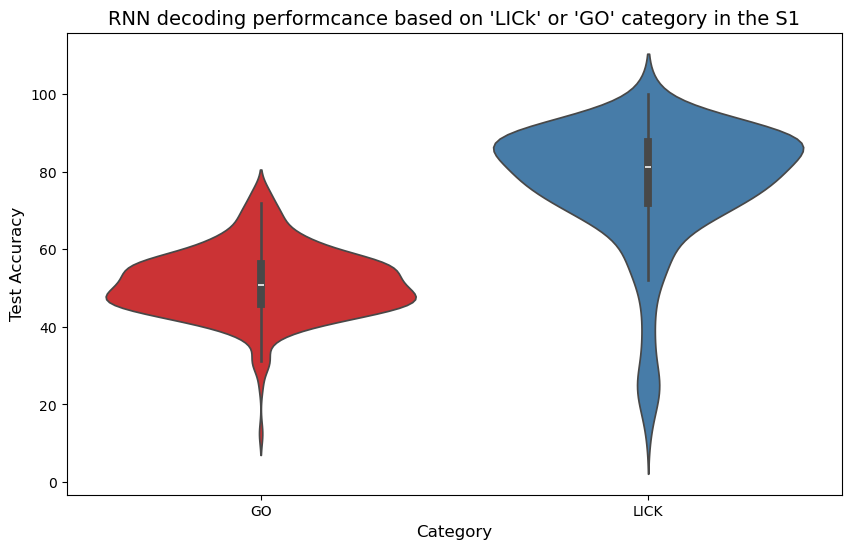

S1naive


/tmp/ipykernel_142/1946043981.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_results[df_results['Brain Area'] == brain_area],


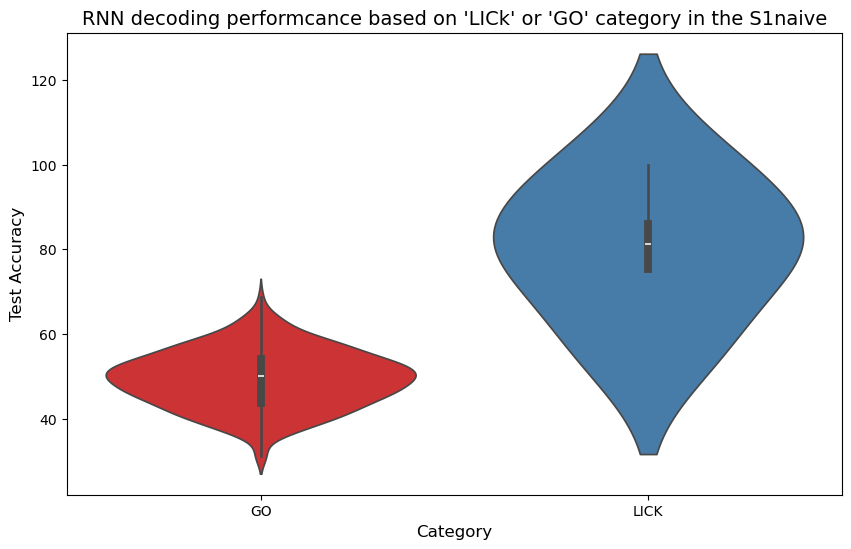

PPC


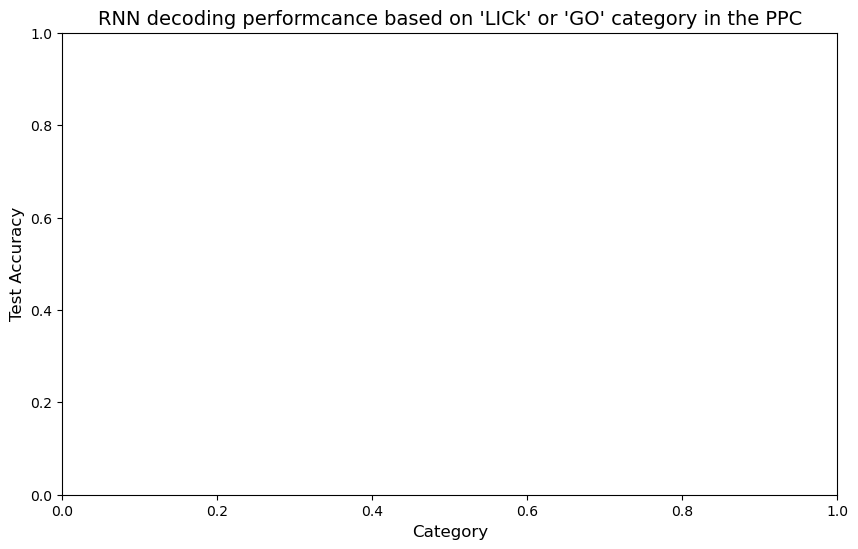

In [11]:
# Create the plot
 
for brain_area in brain_areas:
    print(brain_area)
        
    plt.figure(figsize=(10, 6))
    
    # Use Seaborn scatterplot
    sns.violinplot(data=df_results[df_results['Brain Area'] == brain_area], 
                   x='Analysis Type', 
                   y='Test Accuracy', 
                   palette='Set1')
    
    
    
    # Add title and labels
    title= f"RNN decoding performcance based on 'LICk' or 'GO' category in the {brain_area}"
    plt.title(title, fontsize=14)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    
   
    # Save the plot using the title as the filename
    filename = title.replace(" ", "_").replace("(", "").replace(")", "") + ".png"
    plt.savefig(filename)
    # Display the plot
    plt.show()

In [ ]:
''' The data is very umbalanced therefore we need to consider resampling techniques and class weights . 
The first option is to oversample the minority class:
This involves replicating or generating synthetic samples from the minority class so that its sample count is comparable to the majority class.
The most common technique for this is SMOTE (Synthetic Minority Over-sampling Technique), which creates synthetic examples by interpolating between existing minority class examples.

The second option is to undersample the majority class:
This technique reduces the number of samples from the majority class to balance it with the minority class.
The downside is that you lose potentially useful information from the majority class.

Option 3 is to use a hybrid approach (SMOTE + undersampling)


As for class weights, we can adjust the loss function by assigning higher weights to the minority class so that misclassifications of minority class examples are penalized more heavily.
This ensures that the model gives more importance to the minority class without altering the dataset itself.
'''


In [ ]:
from sklearn.utils import resample

''' SELECT VALUES HERE
This uses weghted loss function to deal with the imbalanced classes 
'''
results_undersampled= []
# Brain areas and analysis types
brain_areas = ["S1", "S1naive", "PPC"]
type_of_analysis = ["GO", "LICK"]

# Create all combinations
combinations = list(itertools.product(brain_areas, type_of_analysis))

# Iterate through each combination
for brain_area, type_of_analysis in combinations:
    print(f"Brain Area: {brain_area}, Analysis Type: {type_of_analysis}")

    all_trials=np.load("processed_data/"+brain_area + "_all_trials.npy",allow_pickle=True)
    trial_list=np.empty((all_trials.shape[0],3))
    trial_dff=np.empty((all_trials.shape[0],41)) 
    trial_licks=np.empty((all_trials.shape[0],41))
    
    
    # Here we get the data based on the conditions that we want (i.e: if it is is lick, or go) 
    
    for trial in range(all_trials.shape[0]):
        
        trial_list[trial,0]=all_trials[trial].neuron_num
    
        
        if type_of_analysis=="GO":
            # for labelling go nogo
            if (all_trials[trial].trial_type)=="go":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_type)=="nogo":
                trial_list[trial,1]=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num )
        elif type_of_analysis=="LICK":    
            #for labelling lick nolick
            if (all_trials[trial].trial_outcome)=="FA":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_outcome)=="Hit":
                trial_list[trial,1]=1
            elif (all_trials[trial].trial_outcome)=="Miss":
                trial_list[trial,1]=0
            elif (all_trials[trial].trial_outcome)=="CR":
                trial_list[trial,1]=0
            else:
                print("gone wrong on neuron ",all_trials[trial].neuron_num )
        else:
            print("Type of analysis can only be 'GO' or 'LICK'")
        
        trial_list[trial,2]=all_trials[trial].mouse_id
        if (all_trials[trial].trial_outcome)=="FA" or (all_trials[trial].trial_outcome)=="Hit":
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #rebase  dff 
            trial_licks[trial,:]=all_trials[trial].licks
            lick_start=np.argmax(trial_licks[trial,:]==1,axis=0)
            trial_dff_rel_licks=np.zeros(trial_licks.shape[1])
            new_start=lick_start-4
            if new_start>=0:                    
                # move the array of licks left so that timeseries starst at lick time
                trial_dff_rel_licks[0:trial_licks.shape[1]-new_start]=all_trials[trial].dff[new_start: ]
                ## need to mske the last few timesteps on the new series = final timestep on original series
                trial_dff_rel_licks[trial_licks.shape[1]-new_start :]=all_trials[trial].dff[-1]
            else: 
                # move the array of licks right so that timeseries starst at lick time
                trial_dff_rel_licks[0-new_start :]=all_trials[trial].dff[0:all_trials[trial].dff.shape[0]+new_start]
                ## need to mske the first few timesteps on the new series = first timestep on original series
                trial_dff_rel_licks[0:-new_start]=all_trials[trial].dff[ 0 ]
                #trial_dff[trial,41:82]=trial_dff_rel_licks
        else:
            trial_dff[trial,0:41]=all_trials[trial].dff 
            #trial_dff[trial,41:82]=all_trials[trial].dff

    print("Array of neuron_num and trial type",trial_list.shape)
    print("Array of dff",trial_dff.shape)
    neuron_list=np.unique(trial_list[:,0]).reshape(-1,1)
    print("Num of neurons before filter=",neuron_list.shape[0])

    for neuron in neuron_list:
        print("\n", neuron, "XXXXXXXXXXXXXXXXXXXX")
    
        neuron_data_list = trial_list[trial_list[:, 0] == neuron].copy()
        neuron_data_dff = trial_dff[trial_list[:, 0] == neuron].copy()
    
        X = neuron_data_dff.copy()
        y = neuron_data_list[:, 1]
        #trying the dims
        X = X.reshape(X.shape[0],X.shape[1],1)
    

        # work on separating the classes for resampling:
        X_majority = X[y == 0]
        X_minority = X[y == 1]
        y_majority = y[y == 0]
        y_minority = y[y == 1]

        #undersample the majority to match the minority class size: 

        X_majority_downsampled, y_majority_downsampled = resample(X_majority, y_majority,
                                                              replace=True,  
                                                              n_samples=len(y_minority),  # Match minority class
                                                              random_state=42)
         # Combine the undersampled majority class with the minority class
        X_balanced = np.vstack((X_majority_downsampled, X_minority))
        y_balanced = np.hstack((y_majority_downsampled, y_minority))

        # Shuffle the balanced dataset
        shuffle_indices = np.random.permutation(len(y_balanced))
        X_balanced = X_balanced[shuffle_indices]
        y_balanced = y_balanced[shuffle_indices]

        #### Train-test split on the balanced data
        X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

       
        # Convert to tensors
        Xtrain = torch.from_numpy(X_train).float()
        ytrain = torch.from_numpy(y_train).long()  # Assuming classification
        Xtest = torch.from_numpy(X_test).float()
        ytest = torch.from_numpy(y_test).long()
    
      
        
        # Batch size, epochs, and iterations
        batch_size = 16
        n_iters = 1000#0
        num_epochs = n_iters // (len(X_train) // batch_size)
        num_epochs = int(num_epochs)
        print(num_epochs)

      
        # Pytorch train and test sets
        train = TensorDataset(Xtrain, ytrain)
        test = TensorDataset(Xtest, ytest)
    
        # Data loaders
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last= True) # this will drop the last batch if its size is less than the batch size, preventing issues caused by small batch sizes
        test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
    
        # Create the RNN model
        input_dim = X.shape[-1]
        hidden_dim = 4
        layer_dim = 1
        output_dim = 1
    
        model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
    
        # Loss function and optimizer WITH WEIGHTS
        error = nn.BCEWithLogitsLoss()
        learning_rate = 0.001
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
        
        loss_list = []
        iteration_list = []
        train_accuracy_list = []
        test_accuracy_list= []
        count = 0
        test_loss_list=[]
        if len(y_test) < batch_size:
             print(f"Skipping neuron {neuron} due to insufficient samples ({len(y_test)} samples, batch size is {batch_size})")
             continue  # Skip this neuron and go to the next one

    
        for epoch in range(num_epochs):
            total_train = 0
            correct_train = 0
            total_test = 0
            correct_test = 0
            model.train()
            for i, (X_batch, y_batch) in enumerate(train_loader):
    
               # print(f"X_batch shape: {X_batch.shape}")
               # print(f"y_batch shape: {y_batch.shape}")
                # Clear gradients
                optimizer.zero_grad()
    
                # Forward pass
                outputs = model(X_batch)
                outputs=outputs.squeeze()
               
                loss = error(outputs, y_batch.float())
    
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Apply sigmoid to get probabilities
                probabilities = torch.sigmoid(outputs)
    
                # Convert probabilities to binary class predictions using a threshold (0.5)
                predicted = (probabilities > 0.5).long()
    
                # Count total number of samples in the batch
                total_train += y_batch.size(0)
               # print("total",total)
                # Count correct predictions
                correct_train += (predicted.squeeze() == y_batch).sum().item()
                     # Calculate accuracy
            train_accuracy = 100 * correct_train / total_train
                #print(f"Train Accuracy: {accuracy:.2f}%")
            train_accuracy_list.append(train_accuracy)
       
                
            scheduler.step()
            correct_test=0
            total_test=0

        
            model.eval()
            with torch.no_grad():
                for X_test_batch, y_test_batch in test_loader:
                    outputs = model(X_test_batch)#.squeeze
                    outputs = outputs.squeeze()
                    #apply sigmoid for accuracy
                    probabilities=torch.sigmoid(outputs)
                 
                    predicted = (probabilities >0.5).long()
                    total_test += y_test_batch.size(0)
                    correct_test += (predicted == y_test_batch).sum().item()
                    loss_test = error(outputs, y_test_batch.float())
                    test_loss_list.append(loss_test)
                    
                test_accuracy = 100 * correct_test / float(total_test)#
                test_accuracy_list.append(test_accuracy)
    
          #  print(f"Test Accuracy: {accuracy:.2f}%")
    
            # Store loss and accuracy
            loss_list.append(np.mean(test_loss_list).item())
            iteration_list.append(count)
            count+=1 
            #print(loss)
            print(f'Epoch: {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%', "loss:", np.mean(test_loss_list))
    
        results_undersampled.append({
                'Brain Area': brain_area,
                'Analysis Type': type_of_analysis,
                'Neuron': neuron,
                'Test Accuracy': test_accuracy
            })
        # Visualization
        plt.plot(iteration_list, loss_list)
        plt.xlabel("Number of iterations")
        plt.ylabel("Loss")
        plt.title("RNN: Loss vs Number of iterations")
        plt.show()
    
        print(len(test_accuracy_list), test_accuracy_list)
    
        plt.plot(iteration_list, test_accuracy_list, color="red", label="test")
        plt.plot(iteration_list, train_accuracy_list, color="blue", label="train")
        plt.xlabel("Number of iterations")
        plt.ylabel("Accuracy")
        plt.title("RNN: Accuracy vs Number of iterations")
        plt.legend()
        plt.show()
        



In [28]:
len(y_batch)

8

In [33]:
#import pandas as pd
# Convert the results to a Pandas DataFrame
df_results = pd.DataFrame(results_undersampled)

# Save the DataFrame to a CSV file
df_results.to_csv('test_accuracies_undersampled.csv', index=False)

S1


/tmp/ipykernel_157/1946043981.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_results[df_results['Brain Area'] == brain_area],


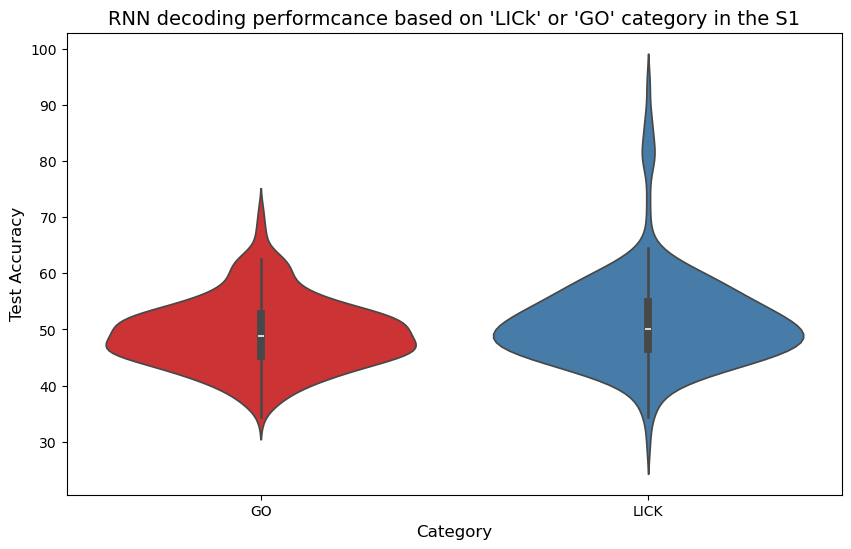

S1naive


/tmp/ipykernel_157/1946043981.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_results[df_results['Brain Area'] == brain_area],


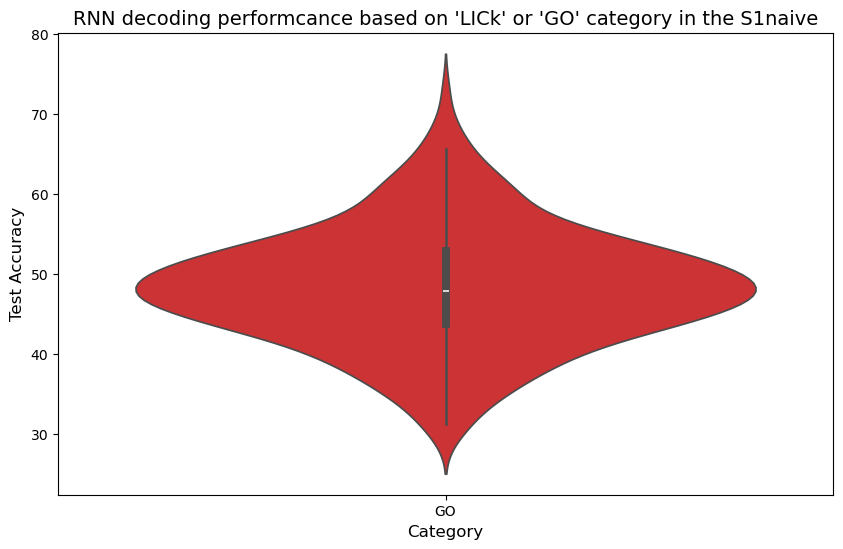

PPC


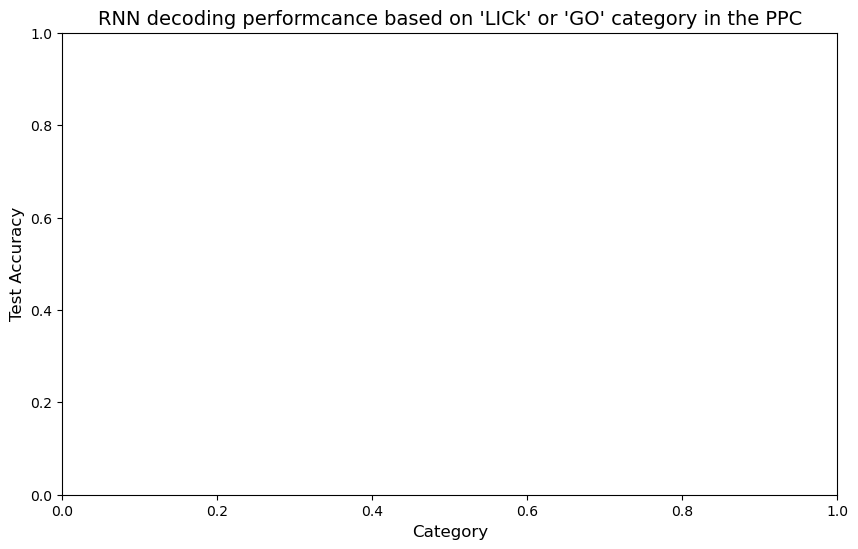

In [34]:
# Create the plot
 
for brain_area in brain_areas:
    print(brain_area)
        
    plt.figure(figsize=(10, 6))
    
    # Use Seaborn scatterplot
    sns.violinplot(data=df_results[df_results['Brain Area'] == brain_area], 
                   x='Analysis Type', 
                   y='Test Accuracy', 
                   palette='Set1')
    
    
    
    # Add title and labels
    title= f"RNN decoding performcance based on 'LICk' or 'GO' category in the {brain_area}"
    plt.title(title, fontsize=14)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    
   
    # Save the plot using the title as the filename
    filename = title.replace(" ", "_").replace("(", "").replace(")", "") + ".png"
    plt.savefig(filename)
    # Display the plot
    plt.show()

S1


/tmp/ipykernel_142/1946043981.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_results[df_results['Brain Area'] == brain_area],


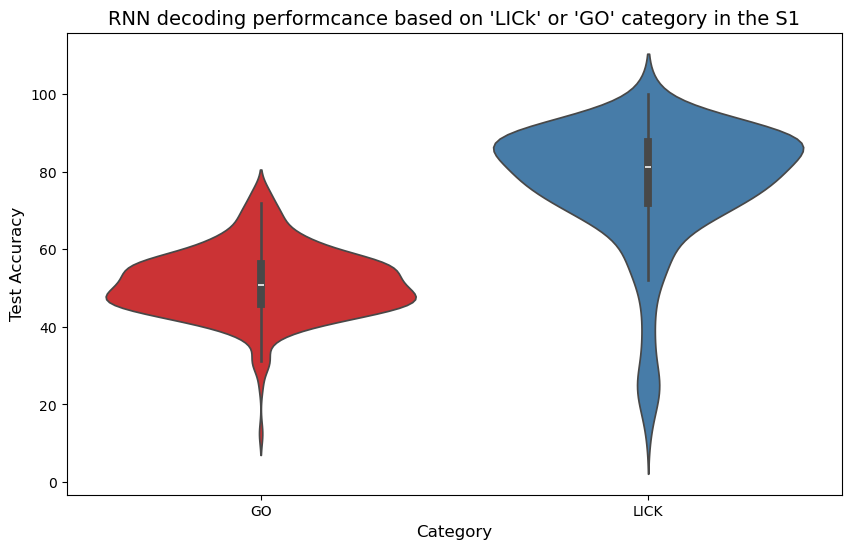

S1naive


/tmp/ipykernel_142/1946043981.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_results[df_results['Brain Area'] == brain_area],


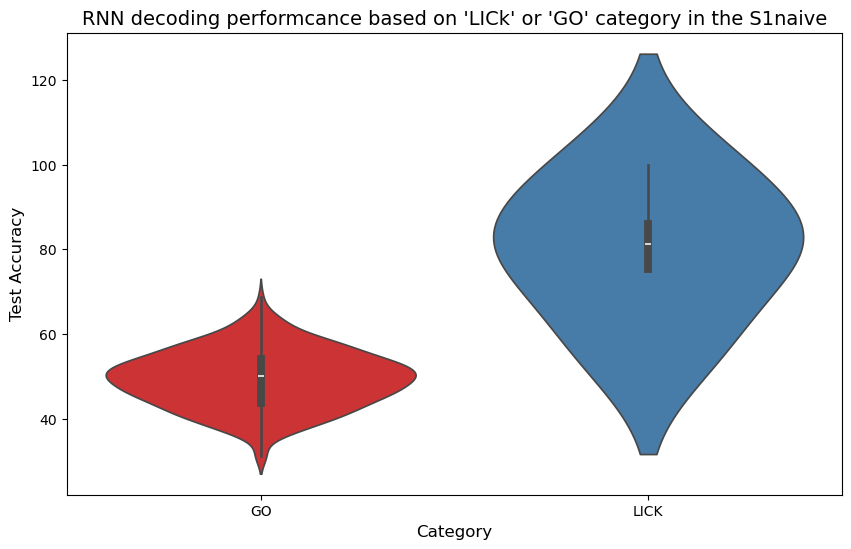

PPC


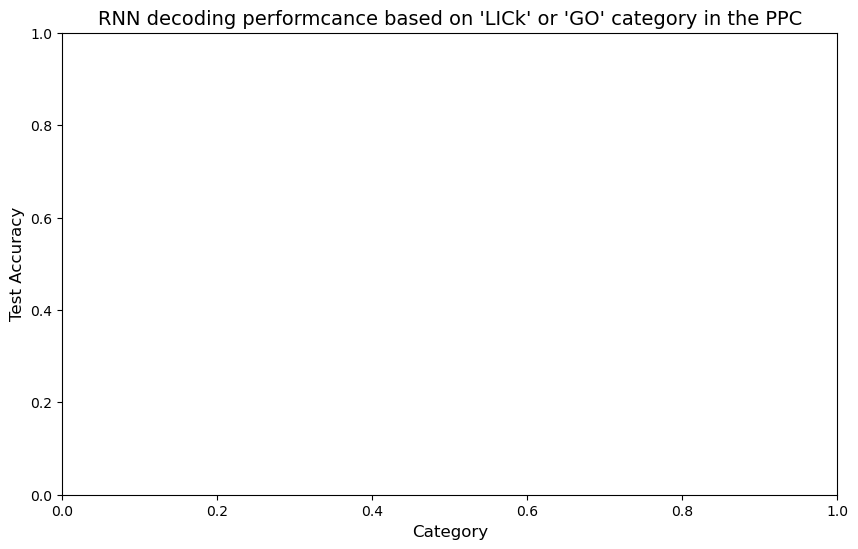

In [11]:
# Create the plot
 
for brain_area in brain_areas:
    print(brain_area)
        
    plt.figure(figsize=(10, 6))
    
    # Use Seaborn scatterplot
    sns.violinplot(data=df_results[df_results['Brain Area'] == brain_area], 
                   x='Analysis Type', 
                   y='Test Accuracy', 
                   palette='Set1')
    
    
    
    # Add title and labels
    title= f"RNN decoding performcance based on 'LICk' or 'GO' category in the {brain_area}"
    plt.title(title, fontsize=14)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    
   
    # Save the plot using the title as the filename
    filename = title.replace(" ", "_").replace("(", "").replace(")", "") + ".png"
    plt.savefig(filename)
    # Display the plot
    plt.show()